In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Latex

import os


save_fig = 'no'





In [90]:
 def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return int(idx)

# Minimum Variance Analysis

In [91]:
from numpy import linalg as LA
# #########################
# #GET MAGNETIC FIELD DATA#
# #########################
def mms_mvab(m1,m2,mag_arr_str):
    mag_arr = pd.read_csv(mag_arr_str,header = 0,names = ['times','Bx','By','Bz','Bmag','date'],
                         parse_dates=['date'])
    m1 = pd.to_datetime(m1)
    m2 = pd.to_datetime(m2)
    # ##########################################################
    # Check for NaN values
    NaNs = mag_arr.isnull().values.any()
    if NaNs == True:
        print,'Nans were found: '
        print, mag_arr.isnull().values.any()
        print,'Replacing with average of surrounding data pts '
        # Indices of NaNs in each component
        NaNs_Bx = np.argwhere(np.isnan(bx))
        NaNs_By = np.argwhere(np.isnan(by))
        NaNs_Bz = np.argwhere(np.isnan(bz))

        # If there are NaNs, replace with the average of surrounding couple of data points
        for i in range(len(NaNs_Bx)):
            bx[NaNs_Bx[i]] = np.nanmean(bx[NaNs_Bx[i-3]:NaNs_Bx[i+3]])
            by[NaNs_By[i]] = np.nanmean(by[NaNs_By[i-3]:NaNs_By[i+3]])
            bz[NaNs_Bz[i]] = np.nanmean(bz[NaNs_Bz[i-3]:NaNs_Bz[i+3]])                           
    time = np.array(mag_arr['times'])
    bx = np.array(pd.to_numeric(mag_arr['Bx']))
    by = np.array(pd.to_numeric(mag_arr['By']))
    bz = np.array(pd.to_numeric(mag_arr['Bz']))
    n1 = mag_arr.date[0]
    n2 = mag_arr.date[len(mag_arr.date)-1]
    if m1 < n1:
        print('WARNING!!! start time of current sheet =',m1, 'start time of B-field data =', n1)
    if m1 > n2:
        print('WARNING!!! start time of current sheet =',m1,'end time of B-field data =',n2)
    if m2 > n2:
        print('WARNING!!! end time of current sheet =',m2,'end time of B-field data =',n2)
    if m2 < n1:
        print('WARNING!!! end time of current sheet =',m2,'start time of B-field data =',n1)
    v1 = mag_arr.date.searchsorted(m1)
    v2 = mag_arr.date.searchsorted(m2)
    bx = bx[v1:v2]
    by = by[v1:v2]
    bz = bz[v1:v2]
    
    
    # create the minimum variance matrix. 
    mm = np.zeros([3, 3])
    bxa = np.mean(bx)
    bya = np.mean(by)
    bza = np.mean(bz)
    mm[0,0] = np.mean(bx*bx) - bxa*bxa
    mm[1,0] = np.mean(bx*by) - bxa*bya
    mm[2,0] = np.mean(bx*bz) - bxa*bza
    mm[0,1] = mm[1,0]
    mm[1,1] = np.mean(by*by) - bya*bya
    mm[2,1] = np.mean(by*bz) - bya*bza
    mm[0,2] = mm[2,0]
    mm[1,2] = mm[2,1]
    mm[2,2] = np.mean(bz*bz) - bza*bza
    
    # The 3 eigenvectors represent directions of maximum, intermediate, and minimum variance of the field
    # component along each vector. 
    
    # The corresponding eigenvalues (λ) represent the actual variances in those field components & are non-negative 
    
    
    # The eigenvector x3 (corresponding to the smallest eigenvalue λ3) is used as the estimator for 
    # the vector normal to the current sheet.
    
    # λ3 represents the variance of the magnetic field component along the estimated normal. 
    
    # The eigenvectors x1 and x2, corresponding to maximum and intermediate variance
    # are tangential to the transition layer
    
    
    
    # eigen vectors should be in GSE coordinate system right?
    eigenvalues, eigenvectors = LA.eig(mm)    
    idx = np.argsort(eigenvalues)
    E_vals_sorted = eigenvalues[idx]
    E_vec_sorted = eigenvectors[:,idx]

    return E_vals_sorted,E_vec_sorted


# Cross-product Normal

In [92]:
# Below are some lines of IDL code to get the cross-product normal.
def Cross_product_normal(E_vals,E_vec,m1,m2,mag_arr_str): 
    mag_arr = pd.read_csv(mag_arr_str,header = 0,names = ['times','Bx','By','Bz','Bmag','date'],
                         parse_dates=['date'])
    m1 = pd.to_datetime(m1)
    m2 = pd.to_datetime(m2)
    
    # lv,mv,nv are in the same coordinate system as the eigenvectors (GSE)
    nv = E_vec[:,0] # take B1 x B2/|B1 x B2|
    lv = E_vec[:,2]
    mv = np.cross(nv,lv)
    rat = E_vals[1]/E_vals[0]
    lxm = lv[0]
    lym = lv[1]
    lzm = lv[2]
    mxm = mv[0]
    mym = mv[1]
    mzm = mv[2]
    nxm = nv[0]
    nym = nv[1]
    nzm = nv[2]
    time = np.array(mag_arr['times'])
    bx = np.array(pd.to_numeric(mag_arr['Bx']))
    by = np.array(pd.to_numeric(mag_arr['By']))
    bz = np.array(pd.to_numeric(mag_arr['Bz']))
    # search the B-field array date column for m1
    v1 = mag_arr.date.searchsorted(m1)
    v2 = mag_arr.date.searchsorted(m2)
    
    # pick a time delta 
    dtb = pd.Timedelta(hours = 0, minutes = 0, seconds = 2)
    v1a = mag_arr.date.searchsorted(m1 - dtb)
    v2a = mag_arr.date.searchsorted(m2 + dtb)
    bv1x = bx[v1a:v1]
    bv1y = by[v1a:v1]
    bv1z = bz[v1a:v1]
    bv2x = bx[v2:v2a]
    bv2y = by[v2:v2a]
    bv2z = bz[v2:v2a]
    bv1avg = np.array([np.mean(bv1x),np.mean(bv1y),np.mean(bv1z)])
    bv2avg = np.array([np.mean(bv2x),np.mean(bv2y),np.mean(bv2z)])
    bmag1 = np.sqrt(np.sum(np.dot(bv1avg,bv1avg)))
    # original bmag2 = np.sqrt(np.sum(np.multiply(bv2avg,bv2avg)))
    bmag2 = np.sqrt(np.sum(np.dot(bv2avg,bv2avg)))
    normal = np.cross(bv1avg,bv2avg)
    normag = np.sqrt(np.sum(np.dot(normal,normal)))
    nc = normal/normag  # N-direction
    # print('nc',nc)
    # print('nc[1]',nc[1])
    # #Angle between cross-product & MVAB normals
    #n12ang = np.arccos(np.sum(nv*nc))*180./!dpi
    
    #not sure if we need this part
    n12ang = np.arccos(np.sum(nv*nc))*180
    # if n12ang >= 90.0:
    #     nc = -nc

# TEST 1
# we want all N_hat to point outward (away from earth) so make sure y component is negative
    if nc[1] > 0:
        print('y coordinate of N is > 0')
        nc = -nc

#    #TEST 2
# # flip $N_{GSE}$ to $-N_{GSE}$ if needed for all events with $N_{y}>0$
    # if nc[1] > 0:
    #     nyc = -nc[1]
    # else:
    #     nyc = nc[1]
        
    mvec = np.cross(nc,E_vec[:,2])
    mmag = np.sqrt(np.sum(np.dot(mvec,mvec)))
    mc = mvec/mmag    # M-direction
    # we also need mz component to be positive
    if mc[2] < 0:
        print('mz negative')
        mc=-mc
        
    # if mzm < 0:
    #     print('mz negative')
    #     mc=-mc
    
    lc = np.cross(mc,nc)  # L-direction
    # angle = np.arccos(np.sum(np.multiply(E_vec[:,2],lc)))*180
    # Angle between cross-product & MVAB normals
    #n12ang = np.arccos(np.sum(np.dot(nv,nc)))*180
    #print('n12ang:',n12ang)
    lxc = lc[0]
    lyc = lc[1]
    lzc = lc[2]
    mxc = mc[0]
    myc = mc[1]
    mzc = mc[2]
    nxc = nc[0]
    nyc = nc[1]
    nzc = nc[2]
    nang = n12ang
    
    # display(Latex(f'$n_c \cdot l_c =$ {np.dot(nc,lc):.2f}')) 
    # display(Latex(f'$m_c \cdot l_c =$ {np.dot(mc,lc):.2f}'))
    # display(Latex(f'$n_c \cdot m_c =$ {np.dot(nc,mc):.2f}'))

#     display(Latex(f"$L_x =$ {lxc:.2f}"))
#     display(Latex(f"$L_y =$ {lyc:.2f}"))
#     display(Latex(f"$L_z =$ {lzc:.2f}"))
    
#     display(Latex(f"$L_xm =$ {lxm:.2f}"))
#     display(Latex(f"$L_ym =$ {lym:.2f}"))
#     display(Latex(f"$L_zm =$ {lzm:.2f}"))
    return lc,mc,nc,lv,mv,nv,mag_arr['date'][v1a],mag_arr['date'][v2a]

# Stefan identified jet candidates

In [93]:

# jet_candidate_timeranges = np.array([['2020-06-17/21:16:50.000','2020-06-17/21:17:10.000'], #3 wonderful example
# ['2020-06-17/21:24:34.000','2020-06-17/21:25:22.000'], #4 
# ['2020-06-17/21:40:49.000','2020-06-17/21:41:23.000'], #6 
# ['2020-06-17/22:18:14.500','2020-06-17/22:18:32.000'], #8 
# ['2020-06-17/22:43:33.000','2020-06-17/22:44:05.000'], #9 2 merging jets
# ['2020-06-17/22:46:24.000','2020-06-17/22:46:39.000'], #10
# ['2020-06-17/23:03:49.000','2020-06-17/23:03:59.000'], #11  great example
# ['2020-06-17/23:10:42.000','2020-06-17/23:10:53.000'], #13 
# ['2020-06-17/23:17:16.000','2020-06-17/23:17:29.000'], #14 
# ['2020-06-17/23:34:54.000','2020-06-17/23:35:18.000'], # 15 
# ['2020-06-17/23:42:45.000','2020-06-17/23:43:02.000'], #17 
# ['2020-06-17/23:49:23.000','2020-06-17/23:49:49.000'], #18 
# ['2020-06-17/23:57:55.000','2020-06-17/23:58:27.000'], #19 
# ['2020-06-18/00:09:40.000','2020-06-18/00:10:06.000'], #21
# ['2020-06-18/00:22:08.000','2020-06-18/00:22:36.000']]) #22

# times_temp =np.array([['2020-06-17/21:16:54.900','2020-06-17/21:17:07.000'], #3 
# ['2020-06-17/21:24:36.000','2020-06-17/21:25:20.000'], #4
# ['2020-06-17/21:40:51.400','2020-06-17/21:41:20.799'], #6 
# ['2020-06-17/22:18:18.200','2020-06-17/22:18:31.000'], #8
# ['2020-06-17/22:43:34.000','2020-06-17/22:44:03.599'], #9
# ['2020-06-17/22:46:25.250','2020-06-17/22:46:38.500'],#10
# ['2020-06-17/23:03:50.000','2020-06-17/23:03:58.000'], #11
# ['2020-06-17/23:10:43.000','2020-06-17/23:10:52.000'], #13
# ['2020-06-17/23:17:17.299','2020-06-17/23:17:28.000'], #14
# ['2020-06-17/23:34:55.400','2020-06-17/23:35:17.500'], #15
# ['2020-06-17/23:42:47.000','2020-06-17/23:42:59.000'], #17
# ['2020-06-17/23:49:26.400','2020-06-17/23:49:46.350'], #18
# ['2020-06-17/23:57:57.599','2020-06-17/23:58:25.000'], #19
# ['2020-06-18/00:09:41.000','2020-06-18/00:10:05.000'], #21
# ['2020-06-18/00:22:09.000','2020-06-18/00:22:35.599']]) #22



# # actual times of the start and stop of current sheet:
#times_temp = np.array([['2020-06-17/21:11:26.000','2020-06-17/21:11:48.000']])#1 
#times_temp = np.array([['2020-06-17/21:16:34.799','2020-06-17/21:16:40.799']]) #2
#times_temp =np.array([['2020-06-17/21:16:55.000','2020-06-17/21:17:07.000']]) #3 #Lentz et al CS #1
#times_temp =np.array([['2020-06-17/21:24:36.000','2020-06-17/21:25:20.000']]) #4 #Lentz et al CS #2
#times_temp =np.array([['2020-06-17/21:29:09.200','2020-06-17/21:29:19.150']])#5 
#times_temp =np.array([['2020-06-17/21:40:51.400','2020-06-17/21:41:20.799']]) #6 #Lentz et al CS #3
#times_temp =np.array([['2020-06-17/22:15:34.000','2020-06-17/22:16:42.000']]) #7
#times_temp = np.array([['2020-06-17/22:18:18.000','2020-06-17/22:18:28.900']]) #8 #Lentz et al CS #4
#times_temp =np.array([['2020-06-17/22:43:34','2020-06-17/22:44:03.599']]) #9 #Lentz et al CS #5
#times_temp =np.array([['2020-06-17/22:46:25.250','2020-06-17/22:46:38.500']])#10 #Lentz et al CS #6
#times_temp =np.array([['2020-06-17/23:03:50.000','2020-06-17/23:03:58.000']]) #11 #Lentz et al CS #7
#times_temp =np.array([['2020-06-17/23:08:35.700','2020-06-17/23:08:57.400']])#12
#times_temp = np.array([['2020-06-17/23:10:43.000','2020-06-17/23:10:52.00']]) #13 #Lentz et al CS #8
#times_temp =np.array([['2020-06-17/23:17:17.299','2020-06-17/23:17:28.000']]) #14 #Lentz et al CS #9
#times_temp =np.array([['2020-06-17/23:34:55.400','2020-06-17/23:35:17.500']]) #15 #Lentz et al CS #10
#times_temp =np.array([['2020-06-17/23:36:57.600','2020-06-17/23:37:26.500']]) #16
#times_temp =np.array([['2020-06-17/23:42:47.000','2020-06-17/23:42:59.000']]) #17 #Lentz et al CS #11
#times_temp =np.array([['2020-06-17/23:49:26.400','2020-06-17/23:49:46.350']]) #18 #Lentz et al CS #12
#times_temp =np.array([['2020-06-17/23:57:57.599','2020-06-17/23:58:25.000']]) #19 #Lentz et al CS #13
#times_temp =np.array([['2020-06-18/00:04:58.599','2020-06-18/00:05:11.099']]) #20
#times_temp =np.array([['2020-06-18/00:09:41.000','2020-06-18/00:10:05.000']]) #21 #Lentz et al CS #14
# # #suggestion to move start time from 00:22:14.000 to 00:22:09.000
times_temp =np.array([['2020-06-18/00:22:09.000','2020-06-18/00:22:35.599']]) #22 #Lentz et al CS #15

# # ################ ################ ################ ################ ################ 
# # # Stefan identified time ranges, but altering the start and stop time to produce best L results
# # ################ ################ ################ ################ ################ 
#jet_candidate_timeranges = np.array([['2020-06-17/21:11:25','2020-06-17/21:11:49']]) #1 
#jet_candidate_timeranges = np.array([['2020-06-17/21:16:32','2020-06-17/21:16:42']]) #2 
#jet_candidate_timeranges = np.array([['2020-06-17/21:16:52','2020-06-17/21:17:09']]) #3 #Lentz et al CS #1

#jet_candidate_timeranges = np.array([['2020-06-17/21:24:34','2020-06-17/21:25:22.00']]) #4 #Lentz et al CS #2
#jet_candidate_timeranges = np.array([['2020-06-17/21:29:08.000','2020-06-17/21:29:20']]) #5
#jet_candidate_timeranges = np.array([['2020-06-17/21:40:49','2020-06-17/21:41:23']]) #6 #Lentz et al CS #3
##jet_candidate_timeranges =np.array([['2020-06-17/22:15:32.000','2020-06-17/22:16:44.000']]) #7 
#jet_candidate_timeranges =np.array([['2020-06-17/22:18:16.802','2020-06-17/22:18:29.000']]) #8 #Lentz et al CS #4
#jet_candidate_timeranges =np.array([['2020-06-17/22:43:33.00','2020-06-17/22:44:05.00']]) #9 #Lentz et al CS #5
#jet_candidate_timeranges=np.array([['2020-06-17/22:46:24.000','2020-06-17/22:46:39.000']])#10 #Lentz et al CS #6
#jet_candidate_timeranges = np.array([['2020-06-17/23:03:49.000','2020-06-17/23:03:59.000']]) #11 #Lentz et al CS #7
#jet_candidate_timeranges = np.array([['2020-06-17/23:08:35.500','2020-06-17/23:08:59.000']])#12
# # # sugggestion to move the jet candidate event end from 2020-06-17/23:11:22.000 to 23:10:52
#jet_candidate_timeranges =np.array([['2020-06-17/23:10:42.000','2020-06-17/23:10:53.000']]) #13 #Lentz et al CS #8
#jet_candidate_timeranges =np.array([['2020-06-17/23:17:16','2020-06-17/23:17:29.000']]) #14  #Lentz et al CS #9
#jet_candidate_timeranges = np.array([['2020-06-17/23:34:54','2020-06-17/23:35:18']]) # 15 #Lentz et al CS #10
#jet_candidate_timeranges =np.array([['2020-06-17/23:36:50.000','2020-06-17/23:37:27.000']]) #16 
#jet_candidate_timeranges =np.array([['2020-06-17/23:42:45.000','2020-06-17/23:43:02.000']]) #17 #Lentz et al CS #11
#jet_candidate_timeranges = np.array([['2020-06-17/23:49:23.000','2020-06-17/23:49:49.000']]) #18 #Lentz et al CS #12
#jet_candidate_timeranges =np.array([['2020-06-17/23:57:55','2020-06-17/23:58:27']]) #19 #Lentz et al CS #13
#jet_candidate_timeranges = np.array([['2020-06-18/00:04:57','2020-06-18/00:05:12']]) # 20 
#jet_candidate_timeranges =np.array([['2020-06-18/00:09:40','2020-06-18/00:10:06']]) #21  #Lentz et al CS #14
jet_candidate_timeranges = np.array([['2020-06-18/00:22:08.000','2020-06-18/00:22:36']]) #22 #Lentz et al CS #15


#Vl_peak = pd.to_datetime('2020-06-17/21:11:35') # 1
#Vl_peak = pd.to_datetime('2020-06-17/21:16:37') # 2
#Vl_peak = np.array(['2020-06-17/21:16:50'])#3
# Vl_peak = pd.to_datetime('2020-06-17/21:25:01' )#4
# Vl_peak = pd.to_datetime('2020-06-17/21:29:15' )#5
#Vl_peak = pd.to_datetime('2020-06-17/21:41:10' )#6
# Vl_peak = pd.to_datetime( '2020-06-17/22:16:13')#7
# Vl_peak = pd.to_datetime( )#8
#Vl_peak = pd.to_datetime('2020-06-17/22:43:50'  )#9
# Vl_peak = pd.to_datetime( )#10
#Vl_peak = pd.to_datetime( '2020-06-17/23:03:54.100')#11
# Vl_peak = pd.to_datetime( )#12
# Vl_peak = pd.to_datetime( )#13
# Vl_peak = pd.to_datetime( '2020-06-17/23:17:22.900')#14
# Vl_peak = pd.to_datetime( '2020-06-17/23:35:08')#15
# Vl_peak = pd.to_datetime( '2020-06-17/23:37:10')#16
# Vl_peak = pd.to_datetime('2020-06-17/23:42:52.500' )#17
# Vl_peak = pd.to_datetime( )#18
# Vl_peak = pd.to_datetime('2020-06-17/23:58:12' )#19
# Vl_peak = pd.to_datetime( )#20
#Vl_peak = pd.to_datetime('2020-06-18/00:09:50.000' )#21
# Vl_peak = pd.to_datetime( )#22

# Vl_peak =np.array(['2020-06-17/21:17:02', #3 
# '2020-06-17/21:25:01', #4 
# '2020-06-17/21:41:10', #6 
# '2020-06-17/22:18:23', #8
# '2020-06-17/22:43:45', #9 #not sure because there are 2 merging jets. maybe take average
# '2020-06-17/22:46:32', #10
# '2020-06-17/23:03:54.100', #11
# '2020-06-17/23:10:52', #13                   
# '2020-06-17/23:17:22.900', #14
# '2020-06-17/23:35:08', #15
# '2020-06-17/23:42:52.500', #17
# '2020-06-17/23:49:42', #18
# '2020-06-17/23:58:12', #19
# '2020-06-18/00:09:50.000', #21
# '2020-06-18/00:22:23']) #22




# Plot BL, BM, BN, VL, VM, VN

In [94]:

from datetime import datetime, timedelta


#########################
Current sheet 2020-06-18/00:22:08.000 - 2020-06-18/00:22:36
MMS1:
#########################
y coordinate of N is > 0
mz negative
L: [ 0.15206427  0.88964415 -0.43059231]
M: [0.8541854  0.10088196 0.51008835]
N: [ 0.49723612 -0.44537188 -0.74458051]


#########################
Current sheet 2020-06-18/00:22:08.000 - 2020-06-18/00:22:36
MMS2:
#########################
y coordinate of N is > 0
mz negative
L: [ 0.13209485  0.90196674 -0.41110454]
M: [0.85510547 0.10607392 0.5074869 ]
N: [ 0.50134378 -0.41857415 -0.75726488]


#########################
Current sheet 2020-06-18/00:22:08.000 - 2020-06-18/00:22:36
MMS3:
#########################
y coordinate of N is > 0
mz negative
L: [ 0.12808207  0.90371149 -0.40853461]
M: [0.85589855 0.10738072 0.50587256]
N: [ 0.50103159 -0.41445738 -0.75973181]


#########################
Current sheet 2020-06-18/00:22:08.000 - 2020-06-18/00:22:36
MMS4:
#########################
y coordinate of N is > 0
mz negative
L: [ 0.1435865

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

max Bm 12.747719508202962
max Bl 3.733858587226691
max $B_M/B_L$ 3.4140873871903334


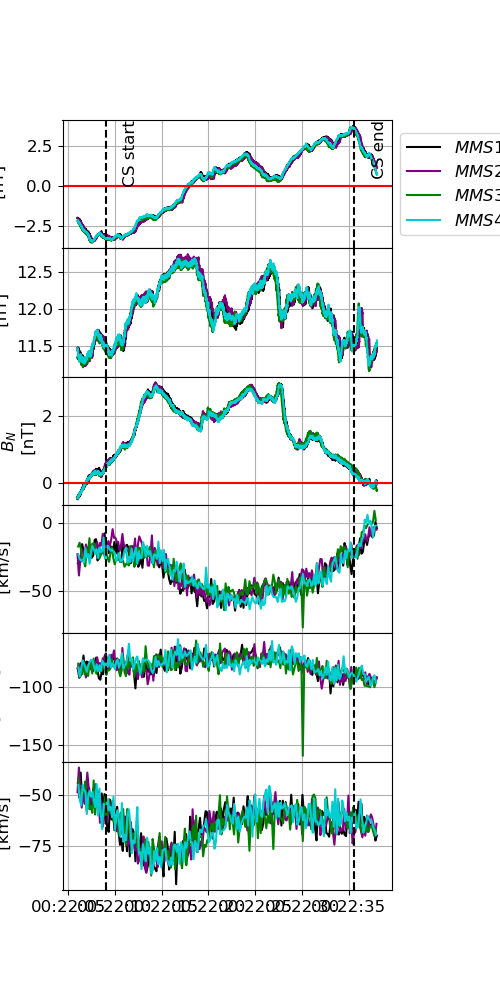

In [95]:
%matplotlib widget
mag_arr_str = ['MMS1_B.csv','MMS2_B.csv','MMS3_B.csv','MMS4_B.csv']
v_arr_str = ['MMS1_Vi.csv','MMS2_Vi.csv','MMS3_Vi.csv','MMS4_Vi.csv']
n_arr_str = ['MMS1_ni.csv','MMS2_ni.csv','MMS3_ni.csv','MMS4_ni.csv']
pressure_anisotropy = 'pressure_anisotropy.csv'

alpha = pd.read_csv(pressure_anisotropy,header = 0,names = ['times','alpha','date'],
                         parse_dates=['date'])



best_lmn_transformations = []
# ΔVA_start=[]
# ΔVA_end =[]
ΔVL_start = []
ΔVL_end = []
V_AL_before=[]
    
V_AL_after =[]
ΔVAL =[]
VL_predicted=[]
#Constants
c = 2.99792458e8  #speed of light (m/s)
m_e = 9.10939e-31         #electron mass (kg)
eps0 = 8.8541878e-12  #epsilon (As/Vm)
e = 1.6022e-19         #charge (C=As)
my = 4.0*1e-7     #my0 (Vs/Am)
mp = 1.672623*1e-27    #proton rest mass  (kg)
kb = 1.38066*1e-23     #Boltzmann constant (J/K) (kg m^2 s^-2)(K^-1)
μ0 = 1.256637061*1e-6 # N A^-2 #kg m s^-2 A^-2



all_Lx =[]
all_Ly =[]
all_Lz =[]

all_Mx =[]
all_My =[]
all_Mz =[]

all_Nx =[]
all_Ny =[]
all_Nz =[]


for i in range(len(jet_candidate_timeranges)):
    # create an array to hold L x,y,z GSE and N x,y,z GSE values to plot
    L_vec = np.empty((5,3))
    N_vec = np.empty((5,3))
    L_vec[0,:]=[0,0,0] # create 0 vector for use in plotting 
    N_vec[0,:]=[0,0,0] # create 0 vector for use in plotting 
    for m in range(len(mag_arr_str)):
        mag_arr = pd.read_csv(mag_arr_str[m],header = 0,names = ['times','Bx','By','Bz','Bmag','date'],parse_dates=['date'])
        v_arr = pd.read_csv(v_arr_str[m],header = 0,names = ['times','Vix','Viy','Viz','date'],parse_dates=['date'])
        n_arr = pd.read_csv(n_arr_str[m],header = 0,names = ['times','ni','date'],parse_dates=['date'])
        # create empty lists to store all of the L M N coordinates in
        all_l = np.empty((len(jet_candidate_timeranges[:,0]),3))
        all_m = np.empty((len(jet_candidate_timeranges[:,0]),3))
        all_n = np.empty((len(jet_candidate_timeranges[:,0]),3))
        
        dtb = pd.Timedelta(hours = 0, minutes = 0, seconds = 2)
    
        m1 = pd.to_datetime(jet_candidate_timeranges[i,0])
        m2 = pd.to_datetime(jet_candidate_timeranges[i,1])
    
        time_b = np.array(mag_arr['times'])
        bx = np.array(pd.to_numeric(mag_arr['Bx']))
        by = np.array(pd.to_numeric(mag_arr['By']))
        bz = np.array(pd.to_numeric(mag_arr['Bz']))
    
        time_v = np.array(v_arr['times'])
        vx = np.array(pd.to_numeric(v_arr['Vix']))
        vy = np.array(pd.to_numeric(v_arr['Viy']))
        vz = np.array(pd.to_numeric(v_arr['Viz']))
        # t5_v = v_arr.date.searchsorted(m1)
        # t6_v = v_arr.date.searchsorted(m2)
        # uncomment to include data during dtb time:
        t5_v = v_arr.date.searchsorted(m1-dtb)
        t6_v = v_arr.date.searchsorted(m2+dtb)
        # print(t5_v)
        # velocity from specified start (t5) and stop(t6) time of current sheet
        vx_t5_t6 = vx[t5_v:t6_v]
        vy_t5_t6 = vy[t5_v:t6_v]
        vz_t5_t6 = vz[t5_v:t6_v]
        time_v_t5_t6 = time_v[t5_v:t6_v]
    
        # search the B-field array date column for m1
        # t5_b = mag_arr.date.searchsorted(m1)
        # t6_b = mag_arr.date.searchsorted(m2)
        # uncomment to include data during dtb time:
        t5_b = mag_arr.date.searchsorted(m1 - dtb)
        t6_b = mag_arr.date.searchsorted(m2 + dtb)
    
        # B-field from specified start (t5) and stop (t6) time of current sheet
        bx_t5_t6 = bx[t5_b:t6_b]
        by_t5_t6 = by[t5_b:t6_b]
        bz_t5_t6 = bz[t5_b:t6_b]
        time_b_t5_t6 = time_b[t5_b:t6_b]
    
        # Find Eigenvalues and Eigen vectors from MVAB analysis
        print('#########################')
        print('Current sheet '+jet_candidate_timeranges[i,0]+' - '+ jet_candidate_timeranges[i,1])
        print('MMS'+str(m+1)+':')
        print('#########################')
        E_vals,E_vec = mms_mvab(m1,m2,mag_arr_str[m])
        lc,mc,nc,lv,mv,nv,v1a,v2a = Cross_product_normal(E_vals,E_vec,jet_candidate_timeranges[i,0],
                                                  jet_candidate_timeranges[i,1],mag_arr_str[m])
        
        print('L:',lc)
        print('M:',mc)
        print('N:',nc)
        print('\n')

        all_Lx.append(lc[0])
        all_Ly.append(lc[1])
        all_Lz.append(lc[2])

        all_Mx.append(mc[0])
        all_My.append(mc[1])
        all_Mz.append(mc[2])

        all_Nx.append(nc[0])
        all_Ny.append(nc[1])
        all_Nz.append(nc[2])

        

    #TEST A
        all_l[i,:] = lv
        all_m[i,:] = mv
        all_n[i,:] = nv

        bn = []
        bl = []
        bm = []
        vn = []
        vl = []
        vm = []
        # for each B-value at each time stamp, project B into LMN coordinates.
        for t in range(len(time_b_t5_t6)):
            bvx_temp = bx_t5_t6[t]
            bvy_temp = by_t5_t6[t]
            bvz_temp = bz_t5_t6[t]
            # create matrix where columns are the x,y,z component at that timestamp to be used in the following dot product
            bvec = np.stack((bvx_temp,bvy_temp,bvz_temp), axis=-1)
            # find dot product between bvec and nc
            bl.append(np.dot(bvec,lc))
            bm.append(np.dot(bvec,mc))
            bn.append(np.dot(bvec,nc))
        # for each v value at each t, project into LMN coordinate system    
        for t in range(len(time_v_t5_t6)):
            # calculate cross product normals using eigen values, eigen vectors, and the start and stop 
            # time for each jet candidate. 
            vx_temp = vx_t5_t6[t]
            vy_temp = vy_t5_t6[t]
            vz_temp = vz_t5_t6[t]
            # create matrix where columns are the x,y,z component at that timestamp to be used in the following dot product
            Vvec = np.stack((vx_temp,vy_temp,vz_temp), axis=-1)
            vl.append(np.dot(Vvec,lc))
            vm.append(np.dot(Vvec,mc))
            vn.append(np.dot(Vvec,nc))


        #print('Vl',vl)
    
        # create a unique string to name files/images based on the start time of the timerange
        string1 = np.array2string(jet_candidate_timeranges[i,0])
        string2 = np.array2string(jet_candidate_timeranges[i,1])
        #print(string)
        time_period_string1 = string1.replace(":", "_")
        time_period_string1 = time_period_string1.replace("/", "_")
        time_period_string1 = time_period_string1.replace("T", "_")
        time_period_string1 = time_period_string1.replace("'", "_")
        #print( time_period_string)
        # time string has .000 or .000000000 remove them for saving
        if len(time_period_string1) > 19:
            time_period_string1 = time_period_string1[0:20]
            #print(string)
    
        time_period_string2 = string2.replace(":", "_")
        time_period_string2 = time_period_string2.replace("/", "_")
        time_period_string2 = time_period_string2.replace("T", "_")
        time_period_string2 = time_period_string2.replace("'", "_")
        if len(time_period_string2) > 19:
            time_period_string2 = time_period_string2[0:20]
            #print(string)
        time_period_string = time_period_string1 + time_period_string2
    
        ################################################
        # Generate B_{LMN} and V_{LMN} data structures!
    ################################################
        if m == 0:
            MMS1_B_LMN = pd.DataFrame({"times": time_b_t5_t6, "Bl": bl,"Bm": bm, "Bn": bn})
            MMS1_V_LMN = pd.DataFrame({"times": time_v_t5_t6, "Vl": vl,"Vm": vm, "Vn": vn})
            MMS1_n = pd.DataFrame({"times": time_v_t5_t6, "n": n_arr['ni'][t5_v:t6_v]})
            MMS1_B_LMN['date'] = pd.to_datetime(MMS1_B_LMN['times'],unit='s',origin='unix')
            MMS1_V_LMN['date'] = pd.to_datetime(MMS1_V_LMN['times'],unit='s',origin='unix')
            MMS1_n['date'] = pd.to_datetime(MMS1_n['times'],unit='s',origin='unix')
            MMS1_L = np.array([[0,0],[lc[0],lc[1]]]) # save the x and y gse component of the L vector
            MMS1_N = np.array([[0,0],[nc[0],nc[1]]]) 
        if m == 1:
            MMS2_B_LMN = pd.DataFrame({"times": time_b_t5_t6, "Bl": bl,"Bm": bm, "Bn": bn})
            MMS2_V_LMN = pd.DataFrame({"times": time_v_t5_t6, "Vl": vl,"Vm": vm, "Vn": vn})
            MMS2_n = pd.DataFrame({"times": time_v_t5_t6, "n": n_arr['ni'][t5_v:t6_v]})
            MMS2_B_LMN['date'] = pd.to_datetime(MMS2_B_LMN['times'],unit='s',origin='unix')
            MMS2_V_LMN['date'] = pd.to_datetime(MMS2_V_LMN['times'],unit='s',origin='unix')
            MMS2_n['date'] = pd.to_datetime(MMS2_n['times'],unit='s',origin='unix')
            MMS2_L = np.array([[0,0],[lc[0],lc[1]]]) # save the x and y gse component of the L vector
            MMS2_N = np.array([[0,0],[nc[0],nc[1]]]) 
        if m == 2:
            MMS3_B_LMN = pd.DataFrame({"times": time_b_t5_t6, "Bl": bl,"Bm": bm, "Bn": bn})
            MMS3_V_LMN = pd.DataFrame({"times": time_v_t5_t6, "Vl": vl,"Vm": vm, "Vn": vn})
            MMS3_n = pd.DataFrame({"times": time_v_t5_t6, "n": n_arr['ni'][t5_v:t6_v]})
            MMS3_B_LMN['date'] = pd.to_datetime(MMS3_B_LMN['times'],unit='s',origin='unix')
            MMS3_V_LMN['date'] = pd.to_datetime(MMS3_V_LMN['times'],unit='s',origin='unix')
            MMS3_n['date'] = pd.to_datetime(MMS3_n['times'],unit='s',origin='unix')       
            MMS3_L = np.array([[0,0],[lc[0],lc[1]]]) # save the x and y gse component of the L vector
            MMS3_N = np.array([[0,0],[nc[0],nc[1]]]) 
        if m == 3:
            MMS4_B_LMN = pd.DataFrame({"times": time_b_t5_t6, "Bl": bl,
                                "Bm": bm, "Bn": bn})
            MMS4_V_LMN = pd.DataFrame({"times": time_v_t5_t6, "Vl": vl,
                                "Vm": vm, "Vn": vn})
            MMS4_n = pd.DataFrame({"times": time_v_t5_t6, "n": n_arr['ni'][t5_v:t6_v]})
            MMS4_B_LMN['date'] = pd.to_datetime(MMS4_B_LMN['times'],unit='s',origin='unix')
            MMS4_V_LMN['date'] = pd.to_datetime(MMS4_V_LMN['times'],unit='s',origin='unix')
            MMS4_n['date'] = pd.to_datetime(MMS4_n['times'],unit='s',origin='unix')   
            MMS4_L = np.array([[0,0],[lc[0],lc[1]]]) # save the x and y gse component of the L vector
            MMS4_N = np.array([[0,0],[nc[0],nc[1]]]) 
    
    fig = plt.figure(figsize=(5,10))
    plt.rcParams.update({'font.size': 12})
    

    ax_BL = fig.add_subplot(611)
    ax_BL.plot(MMS1_B_LMN['date'],MMS1_B_LMN['Bl'], color ='black',label='$MMS1$')
    ax_BL.plot(MMS2_B_LMN['date'],MMS2_B_LMN['Bl'], color ='purple',label='$MMS2$')
    ax_BL.plot(MMS3_B_LMN['date'],MMS3_B_LMN['Bl'], color ='green',label='$MMS3$')
    ax_BL.plot(MMS4_B_LMN['date'],MMS4_B_LMN['Bl'], color ='darkturquoise',label='$MMS4$')
    ax_BL.set_ylabel('$B_L$ \n [nT]')
    ax_BL.grid('on')
    #ax_BL.legend(loc='upper right')
    ax_BL.tick_params( axis='x',labelbottom=False)
    ax_BL.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    ax_BL.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    ax_BL.axhline(y = 0, color = 'r', linestyle='-')

    # ax_BL.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
    # ax_BL.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
    # ax_BL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
    # ax_BL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
    # ax_BL.text(pd.to_datetime(jet_candidate_timeranges[i,0]), 1, '\n $t_1$', color='green', ha='left', va='top', rotation=90,
    #                      transform=ax_BL.get_xaxis_transform())
    # ax_BL.text(pd.to_datetime(jet_candidate_timeranges[i,1]), 1, '\n $t_2$', color='green', ha='left', va='top', rotation=90,
    #                      transform=ax_BL.get_xaxis_transform())
    ax_BL.text(pd.to_datetime(times_temp[i,0]), 1, '\n CS start', color='k', ha='left', va='top', rotation=90,
                         transform=ax_BL.get_xaxis_transform())    
    ax_BL.text(pd.to_datetime(times_temp[i,1]), 1, '\n CS end', color='k', ha='left', va='top', rotation=90,
                         transform=ax_BL.get_xaxis_transform())    
    # ax_BL.text(pd.to_datetime(v1a), 1, '\n $t_1 - \delta t$', color='dimgray', ha='right', va='top', rotation=90,
    #                  transform=ax_BL.get_xaxis_transform())
    # ax_BL.text(pd.to_datetime(v2a), 1, '\n $t_2 + \delta t$', color='dimgray', ha='right', va='top', rotation=90,
    #                  transform=ax_BL.get_xaxis_transform())
    
    ax_BM = fig.add_subplot(612,sharex = ax_BL)
    ax_BM.plot(MMS1_B_LMN['date'],MMS1_B_LMN['Bm'], color ='black',label='$MMS1$')
    ax_BM.plot(MMS2_B_LMN['date'],MMS2_B_LMN['Bm'], color ='purple',label='$MMS2$')
    ax_BM.plot(MMS3_B_LMN['date'],MMS3_B_LMN['Bm'], color ='green',label='$MMS3$')
    ax_BM.plot(MMS4_B_LMN['date'],MMS4_B_LMN['Bm'], color ='darkturquoise',label='$MMS4$')
    ax_BM.set_ylabel('$B_M$ \n [nT]')
    ax_BM.grid('on')
    ax_BM.tick_params( axis='x',labelbottom=False)
    ax_BM.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    ax_BM.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    #ax_BM.set_ylim([-13,-9])
    # ax_BM.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
    # ax_BM.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
    # ax_BM.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
    # ax_BM.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
    
    
    ax_BN = fig.add_subplot(613,sharex = ax_BL)
    ax_BN.plot(MMS1_B_LMN['date'],MMS1_B_LMN['Bn'], color ='black',label='$MMS1$')
    ax_BN.plot(MMS2_B_LMN['date'],MMS2_B_LMN['Bn'], color ='purple',label='$MMS2$')
    ax_BN.plot(MMS3_B_LMN['date'],MMS3_B_LMN['Bn'], color ='green',label='$MMS3$')
    ax_BN.plot(MMS4_B_LMN['date'],MMS4_B_LMN['Bn'], color ='darkturquoise',label='$MMS4$')
    ax_BN.set_ylabel('$B_N$ \n [nT]')
    ax_BN.grid('on')
    ax_BN.tick_params( axis='x',labelbottom=False)
    ax_BN.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    ax_BN.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    #ax_BN.set_ylim([-2,2])
    ax_BN.axhline(y = 0, color = 'r', linestyle='-')
    # ax_BN.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
    # ax_BN.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
    # ax_BN.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
    # ax_BN.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
    
    ax_VL = fig.add_subplot(614,sharex = ax_BL)
    ax_VL.plot(MMS1_V_LMN['date'],MMS1_V_LMN['Vl'], color ='black',label='$MMS1$')
    ax_VL.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vl'], color ='purple',label='$MMS2$')
    ax_VL.plot(MMS3_V_LMN['date'],MMS3_V_LMN['Vl'], color ='green',label='$MMS3$')
    ax_VL.plot(MMS4_V_LMN['date'],MMS4_V_LMN['Vl'], color ='darkturquoise',label='$MMS4$')
    ax_VL.set_ylabel('$V_L$ \n [km/s]')
    ax_VL.grid('on')
    ax_VL.tick_params( axis='x',labelbottom=False)
    ax_VL.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    ax_VL.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    # ax_VL.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
    # ax_VL.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
    # ax_VL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
    # ax_VL.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')

    ax_VM = fig.add_subplot(615,sharex = ax_BL)
    ax_VM.plot(MMS1_V_LMN['date'],MMS1_V_LMN['Vm'], color ='black',label='$MMS1$')
    ax_VM.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vm'], color ='purple',label='$MMS2$')
    ax_VM.plot(MMS3_V_LMN['date'],MMS3_V_LMN['Vm'], color ='green',label='$MMS3$')
    ax_VM.plot(MMS4_V_LMN['date'],MMS4_V_LMN['Vm'], color ='darkturquoise',label='$MMS4$')
    ax_VM.set_ylabel('$V_M$ \n [km/s]')
    ax_VM.grid('on')
    ax_VM.tick_params( axis='x',labelbottom=False)
    ax_VM.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    ax_VM.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    #ax_VM.set_ylim([0,110])

    
    ax_VN = fig.add_subplot(616,sharex = ax_BL)
    ax_VN.plot(MMS1_V_LMN['date'],MMS1_V_LMN['Vn'], color ='black',label='$MMS1$')
    ax_VN.plot(MMS2_V_LMN['date'],MMS2_V_LMN['Vn'], color ='purple',label='$MMS2$')
    ax_VN.plot(MMS3_V_LMN['date'],MMS3_V_LMN['Vn'], color ='green',label='$MMS3$')
    ax_VN.plot(MMS4_V_LMN['date'],MMS4_V_LMN['Vn'], color ='darkturquoise',label='$MMS4$')
    ax_VN.set_ylabel('$V_N$ \n [km/s]')
    ax_VN.grid('on')
    #ax_VN.tick_params( axis='x',labelbottom=False)
    ax_VN.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    ax_VN.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    # ax_VN.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
    # ax_VN.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
    # ax_VN.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
    # ax_VN.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
    
    # ax_N = fig.add_subplot(616,sharex = ax_BL)
    # ax_N.plot(MMS1_n['date'],MMS1_n['n'], color ='black',label='$MMS1$')
    # ax_N.plot(MMS2_n['date'],MMS2_n['n'], color ='purple',label='$MMS2$')
    # ax_N.plot(MMS3_n['date'],MMS3_n['n'], color ='green',label='$MMS3$')
    # ax_N.plot(MMS4_n['date'],MMS4_n['n'], color ='darkturquoise',label='$MMS4$')
    # ax_N.set_ylabel('$n_i$ \n $[cm^{-3}]$')
    # ax_N.grid('on')
    # ax_N.axvline(x = pd.to_datetime(times_temp[i,0]), color = 'k', label = 'start', linestyle='--')
    # ax_N.axvline(x = pd.to_datetime(times_temp[i,1]), color = 'k', label = 'end', linestyle='--')
    # ax_N.axvline(x = pd.to_datetime(v1a), color = 'dimgray')
    # ax_N.axvline(x = pd.to_datetime(v2a), color = 'dimgray')
    # ax_N.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,0]), color = 'green')
    # ax_N.axvline(x = pd.to_datetime(jet_candidate_timeranges[i,1]), color = 'green')
    
    
   # plt.tight_layout()
    plt.subplots_adjust(hspace=0.0)
    # Shrink current axis 
    box = ax_BL.get_position()
    ax_BL.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    # Put a legend to the right of the current axis
    ax_BL.legend(['$MMS1$','$MMS2$','$MMS3$','$MMS4$'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Shrink current axis 
    box = ax_BM.get_position()
    ax_BM.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    # Put a legend to the right of the current axis
    #ax_BM.legend(['$MMS1$','$MMS2$','$MMS3$','$MMS4$'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Shrink current axis 
    box = ax_BN.get_position()
    ax_BN.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    # Put a legend to the right of the current axis
    #ax_BN.legend(['$MMS1$','$MMS2$'','$MMS3$','$MMS4$'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Shrink current axis 
    box = ax_VL.get_position()
    ax_VL.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    # Put a legend to the right of the current axis
    #ax_VL.legend(['$MMS1$','$MMS2$','$MMS3$','$MMS4$'],loc='center left', bbox_to_anchor=(1, 0.5))

    box = ax_VM.get_position()
    ax_VM.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    
    box = ax_VN.get_position()
    ax_VN.set_position([box.x0, box.y0, box.width * 0.85, box.height])
  
    # add panel letters
    # ax_BL.text(pd.to_datetime('2020-06-17/21:16:50'), .9, 'g)', color='k', ha='left', va='center',
    #                      transform=ax_BL.get_xaxis_transform())    
    # ax_BM.text(pd.to_datetime('2020-06-17/21:16:50'), .9, 'h)', color='k', ha='left', va='center',
    #                      transform=ax_BM.get_xaxis_transform()) 
    # ax_BN.text(pd.to_datetime('2020-06-17/21:16:50'), .9, 'i)', color='k', ha='left', va='top',
    #                      transform=ax_BN.get_xaxis_transform()) 
    # ax_VL.text(pd.to_datetime('2020-06-17/21:16:50'), .9, 'j)', color='k', ha='left', va='top',
    #                      transform=ax_VL.get_xaxis_transform())    
    # ax_VM.text(pd.to_datetime('2020-06-17/21:16:50'), .9, 'k)', color='k', ha='left', va='top',
    #                      transform=ax_VM.get_xaxis_transform()) 
    # ax_VN.text(pd.to_datetime('2020-06-17/21:16:50'), .9, 'l)', color='k', ha='left', va='top',
    #                      transform=ax_VN.get_xaxis_transform())     
    if save_fig == 'yes':
        fig.savefig('all_MMS_LMN' + time_period_string +'.png', format='png', dpi=300)


display(Latex(f'average $L:$  {np.mean(all_Lx):.2f}, {np.mean(all_Ly):.2f}, {np.mean(all_Lz):.2f}')) 
display(Latex(f'average $M:$  {np.mean(all_Mx):.2f}, {np.mean(all_My):.2f}, {np.mean(all_Mz):.2f}')) 
display(Latex(f'average $N:$  {np.mean(all_Nx):.2f}, {np.mean(all_Ny):.2f}, {np.mean(all_Nz):.2f}')) 


L_unit = np.sqrt(np.mean(all_Lx)**2 + np.mean(all_Ly)**2 + np.mean(all_Lz)**2)
M_unit = np.sqrt(np.mean(all_Mx)**2 + np.mean(all_My)**2 + np.mean(all_Mz)**2)
N_unit = np.sqrt(np.mean(all_Nx)**2 + np.mean(all_Ny)**2 + np.mean(all_Nz)**2)


display(Latex(f'summed squared $L:$  {L_unit:.2f}')) 
display(Latex(f'summed squared $M:$  {M_unit:.2f}'))
display(Latex(f'summed squared $N:$  {N_unit:.2f}')) 

# print the maximum BM reached
# print maximum BL reached

all_BM = np.concatenate((np.array(MMS1_B_LMN['Bm']),np.array(MMS2_B_LMN['Bm']),np.array(MMS3_B_LMN['Bm']),np.array(MMS4_B_LMN['Bm'])),axis=0)
all_BL = np.concatenate((np.array(MMS1_B_LMN['Bl']),np.array(MMS2_B_LMN['Bl']),np.array(MMS3_B_LMN['Bl']),np.array(MMS4_B_LMN['Bl'])),axis=0)

print('max Bm', np.max(all_BM))
print('max Bl', np.max(all_BL))

print('max $B_M/B_L$', np.max(all_BM)/np.max(all_BL))


# Walen Analysis

In [96]:
  # before_CS_t1_b = MMS1_B_LMN.date.searchsorted(pd.to_datetime(jet_candidate_timeranges[i,0]))
    # before_CS_t2_b =  MMS1_B_LMN.date.searchsorted(pd.to_datetime(times_temp[i,0]))
    # ave_BL_before_CS = np.mean([MMS1_B_LMN['Bl'][before_CS_t1_b:before_CS_t2_b],
    #                             MMS2_B_LMN['Bl'][before_CS_t1_b:before_CS_t2_b],
    #                             MMS3_B_LMN['Bl'][before_CS_t1_b:before_CS_t2_b],MMS4_B_LMN['Bl'][before_CS_t1_b:before_CS_t2_b]])
    
    
    # before_CS_t1_n = MMS1_n.date.searchsorted(pd.to_datetime(jet_candidate_timeranges[i,0]))
    # before_CS_t2_n =  MMS1_n.date.searchsorted(pd.to_datetime(times_temp[i,0]))
    # ave_n_before_CS = np.mean([MMS1_n['n'][before_CS_t1_n:before_CS_t2_n],MMS2_n['n'][before_CS_t1_n:before_CS_t2_n],MMS3_n['n'][before_CS_t1_n:before_CS_t2_n],MMS4_n['n'][before_CS_t1_n:before_CS_t2_n]])
    
    
    # before_CS_t1_v = MMS1_V_LMN.date.searchsorted(pd.to_datetime(jet_candidate_timeranges[i,0]))
    # before_CS_t2_v =  MMS1_V_LMN.date.searchsorted(pd.to_datetime(times_temp[i,0]))
    # ave_VL_before_CS.append(np.mean([MMS1_V_LMN['Vl'][before_CS_t1_v:before_CS_t2_v],
    #                                  MMS2_V_LMN['Vl'][before_CS_t1_v:before_CS_t2_v],
    #                                  MMS3_V_LMN['Vl'][before_CS_t1_v:before_CS_t2_v],MMS4_V_LMN['Vl'][before_CS_t1_v:before_CS_t2_v]]))
    
    # V_AL_before.append((((ave_BL_before_CS)*1e-9)/np.sqrt(μ0*mp*(ave_n_before_CS)*1e6))/1000)
    
    
    
    # after_CS_t2_b = MMS1_B_LMN.date.searchsorted(pd.to_datetime(jet_candidate_timeranges[i,1]))
    # after_CS_t1_b =  MMS1_B_LMN.date.searchsorted(pd.to_datetime(times_temp[i,1]))
    # ave_BL_after_CS = np.mean([MMS1_B_LMN['Bl'][after_CS_t1_b:after_CS_t2_b],MMS2_B_LMN['Bl'][after_CS_t1_b:after_CS_t2_b],MMS3_B_LMN['Bl'][after_CS_t1_b:after_CS_t2_b],MMS4_B_LMN['Bl'][after_CS_t1_b:after_CS_t2_b]])
    
    # after_CS_t2_n = MMS1_n.date.searchsorted(pd.to_datetime(jet_candidate_timeranges[i,1]))
    # after_CS_t1_n =  MMS1_n.date.searchsorted(pd.to_datetime(times_temp[i,1]))
    # ave_n_after_CS = np.mean([MMS1_n['n'][after_CS_t1_n:after_CS_t2_n],MMS2_n['n'][after_CS_t1_n:after_CS_t2_n],MMS3_n['n'][after_CS_t1_n:after_CS_t2_n],MMS4_n['n'][after_CS_t1_n:after_CS_t2_n]])
    
    
    # after_CS_t2_v = MMS1_V_LMN.date.searchsorted(pd.to_datetime(jet_candidate_timeranges[i,1]))
    # after_CS_t1_v =  MMS1_V_LMN.date.searchsorted(pd.to_datetime(times_temp[i,1]))
    # ave_VL_after_CS.append(np.mean([MMS1_V_LMN['Vl'][after_CS_t1_v:after_CS_t2_v],
    #                                 MMS2_V_LMN['Vl'][after_CS_t1_v:after_CS_t2_v],
    #                                 MMS3_V_LMN['Vl'][after_CS_t1_v:after_CS_t2_v],MMS4_V_LMN['Vl'][after_CS_t1_v:after_CS_t2_v]]))
    
    # V_AL_after.append((((ave_BL_after_CS)*1e-9)/np.sqrt(μ0*mp*(ave_n_after_CS)*1e6))/1000)
    # take average values 1 second before the start of the CS (t1) to 1 second after the start of the CS (t2)



   # Start of CS:
    
    ave_BL_CS_start_t1 = ave_n_CS_start_t1= ave_VL_CS_start_t1 =pd.to_datetime(times_temp[i,0]) - timedelta(seconds=1)
    ave_BL_CS_start_t2 = ave_n_CS_start_t2= ave_VL_CS_start_t2 =pd.to_datetime(times_temp[i,0]) + timedelta(seconds=1)

    ave_BL_CS_start = np.mean([np.array(MMS1_B_LMN['Bl'][MMS1_B_LMN.date.searchsorted(ave_BL_CS_start_t1):MMS1_B_LMN.date.searchsorted(ave_BL_CS_start_t2)]),
    np.array(MMS2_B_LMN['Bl'][MMS2_B_LMN.date.searchsorted(ave_BL_CS_start_t1):MMS2_B_LMN.date.searchsorted(ave_BL_CS_start_t2)]),
    np.array(MMS3_B_LMN['Bl'][MMS3_B_LMN.date.searchsorted(ave_BL_CS_start_t1):MMS3_B_LMN.date.searchsorted(ave_BL_CS_start_t2)]),
    np.array(MMS4_B_LMN['Bl'][MMS4_B_LMN.date.searchsorted(ave_BL_CS_start_t1):MMS4_B_LMN.date.searchsorted(ave_BL_CS_start_t2)])])

    

    # numpy is pissing me off, why is this so difficult to take a mean!?
    a=np.array(MMS1_n['n'][MMS1_n.date.searchsorted(ave_n_CS_start_t1):MMS1_n.date.searchsorted(ave_n_CS_start_t2)])
    b=np.array(MMS2_n['n'][MMS2_n.date.searchsorted(ave_n_CS_start_t1):MMS2_n.date.searchsorted(ave_n_CS_start_t2)])
    c=np.array(MMS3_n['n'][MMS3_n.date.searchsorted(ave_n_CS_start_t1):MMS3_n.date.searchsorted(ave_n_CS_start_t2)])
    d=np.array(MMS4_n['n'][MMS4_n.date.searchsorted(ave_n_CS_start_t1):MMS4_n.date.searchsorted(ave_n_CS_start_t2)])
    
    f=np.concatenate((a, b,c,d))
    ave_n_CS_start = np.mean(f)
    
    a3 = np.array(MMS1_V_LMN['Vl'][MMS1_V_LMN.date.searchsorted(ave_VL_CS_start_t1):MMS1_V_LMN.date.searchsorted(ave_VL_CS_start_t2)])
    b3 = np.array(MMS2_V_LMN['Vl'][MMS2_V_LMN.date.searchsorted(ave_VL_CS_start_t1):MMS2_V_LMN.date.searchsorted(ave_VL_CS_start_t2)])
    c3 = np.array(MMS3_V_LMN['Vl'][MMS3_V_LMN.date.searchsorted(ave_VL_CS_start_t1):MMS3_V_LMN.date.searchsorted(ave_VL_CS_start_t2)])
    d3 = np.array(MMS4_V_LMN['Vl'][MMS4_V_LMN.date.searchsorted(ave_VL_CS_start_t1):MMS4_V_LMN.date.searchsorted(ave_VL_CS_start_t2)])
    f3=np.concatenate((a3, b3,c3,d3))
    ave_VL_CS_start =  np.mean(f3)




#VA_peak = 
    ΔVAL1 = np.abs((((ave_BL_peak)*1e-9)/np.sqrt(μ0*mp*(ave_n_peak)*1e6))/1000) - np.abs((((ave_BL_CS_start)*1e-9)/np.sqrt(μ0*mp*(ave_n_CS_start)*1e6))/1000)
    ΔVAL.append(ΔVAL1)

    VL_predicted1 = ave_VL_CS_start + ΔVAL1


    VL_predicted.append(VL_predicted1)
    
    # ave_BL_CS_end_t1 = ave_n_CS_end_t1 = ave_VL_CS_end_t1 = pd.to_datetime(times_temp[i,1]) - timedelta(seconds=1)
    # ave_BL_CS_end_t2 = ave_n_CS_end_t2 = ave_VL_CS_end_t2 = pd.to_datetime(times_temp[i,1]) + timedelta(seconds=1)
    # ave_peak_t1 = pd.to_datetime(Vl_peak[i]) - timedelta(seconds=1)
    # ave_peak_t2 = pd.to_datetime(Vl_peak[i]) + timedelta(seconds=1)
    
    
   
    
    
    
    
    # ave_BL_CS_end = np.mean([np.array(MMS1_B_LMN['Bl'][MMS1_B_LMN.date.searchsorted(ave_BL_CS_end_t1):MMS1_B_LMN.date.searchsorted(ave_BL_CS_end_t2)]),
    # np.array(MMS2_B_LMN['Bl'][MMS2_B_LMN.date.searchsorted(ave_BL_CS_end_t1):MMS2_B_LMN.date.searchsorted(ave_BL_CS_end_t2)]),
    # np.array(MMS3_B_LMN['Bl'][MMS3_B_LMN.date.searchsorted(ave_BL_CS_end_t1):MMS3_B_LMN.date.searchsorted(ave_BL_CS_end_t2)]),
    # np.array(MMS4_B_LMN['Bl'][MMS4_B_LMN.date.searchsorted(ave_BL_CS_end_t1):MMS4_B_LMN.date.searchsorted(ave_BL_CS_end_t2)])])
    
    
    
    
    # a1= np.array(MMS1_n['n'][MMS1_n.date.searchsorted(ave_n_CS_end_t1):MMS1_n.date.searchsorted(ave_n_CS_end_t2)])
    # b1=np.array(MMS2_n['n'][MMS2_n.date.searchsorted(ave_n_CS_end_t1):MMS2_n.date.searchsorted(ave_n_CS_end_t2)])
    # c1=np.array(MMS3_n['n'][MMS3_n.date.searchsorted(ave_n_CS_end_t1):MMS3_n.date.searchsorted(ave_n_CS_end_t2)])
    # d1=np.array(MMS4_n['n'][MMS4_n.date.searchsorted(ave_n_CS_end_t1):MMS4_n.date.searchsorted(ave_n_CS_end_t2)])
    # f1=np.concatenate((a1, b1,c1,d1))
    # ave_n_CS_end =  np.mean(f1)
    

    
    
    
    
    
    
    
    # a4 = np.array(MMS1_V_LMN['Vl'][MMS1_V_LMN.date.searchsorted(ave_VL_CS_end_t1):MMS1_V_LMN.date.searchsorted(ave_VL_CS_end_t2)])
    # b4 = np.array(MMS2_V_LMN['Vl'][MMS2_V_LMN.date.searchsorted(ave_VL_CS_end_t1):MMS2_V_LMN.date.searchsorted(ave_VL_CS_end_t2)])
    # c4 = np.array(MMS3_V_LMN['Vl'][MMS3_V_LMN.date.searchsorted(ave_VL_CS_end_t1):MMS3_V_LMN.date.searchsorted(ave_VL_CS_end_t2)])
    # d4 = np.array(MMS4_V_LMN['Vl'][MMS4_V_LMN.date.searchsorted(ave_VL_CS_end_t1):MMS4_V_LMN.date.searchsorted(ave_VL_CS_end_t2)])
    # f4=np.concatenate((a4, b4,c4,d4))
    # ave_VL_CS_end =   np.mean(f4)

    # # MMS1_v1=MMS1_V_LMN.reset_index(drop=True)
    # # MMS2_v1=MMS2_V_LMN.reset_index(drop=True)
    # # MMS3_v1=MMS3_V_LMN.reset_index(drop=True)
    # # MMS4_v1=MMS4_V_LMN.reset_index(drop=True)
    
    # # ave_VL_peak = np.mean([np.array(MMS1_v1['Vl'][MMS1_v1.date.searchsorted(ave_peak_t1):MMS1_v1.date.searchsorted(ave_peak_t2)]),
    # # np.array(MMS2_v1['Vl'][MMS2_v1.date.searchsorted(ave_peak_t1):MMS2_v1.date.searchsorted(ave_peak_t2)]),
    # # np.array(MMS3_v1['Vl'][MMS3_v1.date.searchsorted(ave_peak_t1):MMS3_v1.date.searchsorted(ave_peak_t2)]),
    # # np.array(MMS4_v1['Vl'][MMS4_v1.date.searchsorted(ave_peak_t1):MMS4_v1.date.searchsorted(ave_peak_t2)])])
    # a7 = np.array(MMS1_V_LMN['Vl'][MMS1_V_LMN.date.searchsorted(ave_peak_t1):MMS1_V_LMN.date.searchsorted(ave_peak_t2)])
    # b7 = np.array(MMS2_V_LMN['Vl'][MMS2_V_LMN.date.searchsorted(ave_peak_t1):MMS2_V_LMN.date.searchsorted(ave_peak_t2)])
    # c7 = np.array(MMS3_V_LMN['Vl'][MMS3_V_LMN.date.searchsorted(ave_peak_t1):MMS3_V_LMN.date.searchsorted(ave_peak_t2)])
    # d7 = np.array(MMS4_V_LMN['Vl'][MMS4_V_LMN.date.searchsorted(ave_peak_t1):MMS4_V_LMN.date.searchsorted(ave_peak_t2)])
    # f7=np.concatenate((a7, b7,c7,d7))
    # ave_VL_peak =   np.mean(f7)

    # MMS1_b1=MMS1_B_LMN.reset_index(drop=True)
    # MMS2_b1=MMS2_B_LMN.reset_index(drop=True)
    # MMS3_b1=MMS3_B_LMN.reset_index(drop=True)
    # MMS4_b1=MMS4_B_LMN.reset_index(drop=True)
        
    # ave_BL_peak = np.mean([np.array(MMS1_b1['Bl'][MMS1_b1.date.searchsorted(ave_peak_t1):MMS1_b1.date.searchsorted(pd.to_datetime(ave_peak_t2))]),
    # np.array(MMS2_b1['Bl'][MMS2_b1.date.searchsorted(ave_peak_t1):MMS2_b1.date.searchsorted(ave_peak_t2)]),
    # np.array(MMS3_b1['Bl'][MMS3_b1.date.searchsorted(ave_peak_t1):MMS3_b1.date.searchsorted(ave_peak_t2)]),
    # np.array(MMS4_b1['Bl'][MMS4_b1.date.searchsorted(ave_peak_t1):MMS4_b1.date.searchsorted(ave_peak_t2)])])
    
    
    
    
  

    # V_AL_before.append(np.abs((((ave_BL_CS_start)*1e-9)/np.sqrt(μ0*mp*(ave_n_CS_start)*1e6))/1000))
    # V_AL_after.append(np.abs((((ave_BL_CS_end)*1e-9)/np.sqrt(μ0*mp*(ave_n_CS_end)*1e6))/1000))
    
    # #VA_peak = (((ave_BL_peak)*1e-9)/np.sqrt(μ0*mp*(ave_n_peak)*1e6))/1000
    
    
    # ΔVL_start.append(np.abs(ave_VL_peak - ave_VL_CS_start))
    # ΔVL_end.append(np.abs(ave_VL_peak - ave_VL_CS_end))
    
    
    # ΔVA_start.append(VA_peak - V_AL_before)
    # ΔVA_end.append(VA_peak - V_AL_after)

IndentationError: unexpected indent (770145580.py, line 45)

In [ ]:
# Plot the new LMN coordinate system compared to GSE coordinate system

# Show LMN GSE coordinate components relative to XYZ GSE coordinates

In [ ]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111)


# L_GSE = np.empty((len(jet_candidate_timeranges[:,0])+1,3))
# M_GSE = np.empty((len(jet_candidate_timeranges[:,0])+1,3))
# N_GSE = np.empty((len(jet_candidate_timeranges[:,0])+1,3))
# L_GSE[0,:] = [0,0,0]
# M_GSE[0,:] = [0,0,0]
# N_GSE[0,:] = [0,0,0]

# for i in range(len(jet_candidate_timeranges)):
#     L_GSE[i+1,:] = [all_l[i,0],all_l[i,1],all_l[i,2]]
#     M_GSE[i+1,:] = [all_m[i,0],all_m[i,1],all_m[i,2]]
#     N_GSE[i+1,:] = [all_n[i,0],all_n[i,1],all_n[i,2]]
                     
#     xs = np.array([[0,0],[all_l[i,0],all_l[i,1]]])
#     ys = np.array([[0,0],[all_n[i,0],all_n[i,1]]])

#     ax.plot(xs[:,0],xs[:,1],color='darkturquoise',label='L')
#     ax.plot(ys[:,0],ys[:,1],color='purple',label='N')

# ax.set_xlabel('$X_{GSE}$')
# ax.set_ylabel('$Y_{GSE}$')
# ax.axvline(x = 0, color = 'k')
# ax.axhline(y = 0, color = 'k')
# ax.legend()
# ax.set_ylim([-1,1])
# ax.set_xlim([-1,1])
# ax.set_title('LN Vectors \n '+str(jet_candidate_timeranges[i,0])+' - '+str(jet_candidate_timeranges[i,1]))


# # ax.set_yticklabels([])
# # ax.set_xticklabels([])
# plt.tight_layout()
# plt.show()

# if save_fig == 'yes':
#     fig.savefig('LN_vectors_' + time_period_string)

# Compare change in L component of V to predicted Alfvén speed

In [ ]:

# display(Latex(f' Before CS $V_AL =$ {V_AL_before:.2f} km/s')) 
# display(Latex(f'Before CS $V_L =$ {ave_VL_before_CS:.2f} km/s')) 


# # display(Latex(f' After CS $V_AL =$ {V_AL_after:.2f} km/s')) 
# # display(Latex(f'After CS $V_L =$ {ave_VL_after_CS:.2f} km/s')) 
# print('$V_{L,peak}$= ',ave_VL_peak)
# print('$V_{AL,start}$= ',V_AL_before)
# print('$V_{AL,end}$= ',V_AL_after)
# print('$V_{L,peak}-V_{AL,start}$ = ',ave_VL_peak-V_AL_before)
# print('$V_{L,peak}-V_{AL,end}$ = ',ave_VL_peak-V_AL_after)
# # display(Latex('$x = \\frac{-b \\pm \\sqrt{b^{2} - 4ac}}{2a}$'))

In [ ]:

# import matplotlib.cm as cm
# fig = plt.figure(figsize=(10,10))
# plt.rcParams.update({'font.size': 12})
# ax = fig.add_subplot(111)


# # ΔVAL =[]
# # VL_predicted

# ax.scatter(VL_predicted,VL_predicted, color='darkseagreen',label='start of CS')
# #ax.scatter(ΔVL_end,V_AL_after, color='maroon',label='end of CS')


# n = [3, 4, 6,8,9,10,11,13,14,15,17,18,19,21,22]


# # for i, txt in enumerate(n):
# #     ax.annotate(txt, (ΔVL_start[i], V_AL_before[i]))
# #     ax.annotate(txt, (ΔVL_end[i], V_AL_after[i]))

# ax.set_ylabel('Predicted values \n $V_{A} = V{A,ave}$ \n [km/s]')
# ax.set_xlabel('Observed values \n $ΔV_{L}=V_{L,peak} - V_{L,ave}$ \n [km/s]')

# ax.set_ylabel('Predicted values \n $V_{A} = V{A,ave}$ \n [km/s]')
# ax.set_xlabel('Observed values \n $ΔV_{L}=V_{L,peak} - V_{L,ave}$ \n [km/s]')

# ax.grid()
# # ax.set_yscale('log')
# # ax.set_xscale('log')
# ax.legend()
# plt.show()